<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Collecting-all-MAGs" data-toc-modified-id="Collecting-all-MAGs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Collecting all MAGs</a></span><ul class="toc-item"><li><span><a href="#Checkm-info-for-dRep" data-toc-modified-id="Checkm-info-for-dRep-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Checkm info for dRep</a></span></li></ul></li><li><span><a href="#dRep" data-toc-modified-id="dRep-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>dRep</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Adding-info" data-toc-modified-id="Adding-info-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Adding info</a></span></li><li><span><a href="#checkm" data-toc-modified-id="checkm-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>checkm</a></span><ul class="toc-item"><li><span><a href="#gtdbtk" data-toc-modified-id="gtdbtk-5.1.2.1"><span class="toc-item-num">5.1.2.1&nbsp;&nbsp;</span>gtdbtk</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#checkM" data-toc-modified-id="checkM-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>checkM</a></span></li><li><span><a href="#GTDBTk" data-toc-modified-id="GTDBTk-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>GTDBTk</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* dRep all MAGs (all per-host-class assemblies) & run QC on them
* using modified LLMGA pipeline to do it

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary/'
MAG_dir = file.path(work_dir, 'MAGs')
tmp_out_dir = '/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata/'

# per host class assemblies
projects = c(
'MG_assembly_act',
'MG_assembly_amp',
'MG_assembly_ave',
'MG_assembly_mam',
'MG_assembly_rep'
)

# params
threads = 24
ani = 0.95
conda_env = 'metacompass'

# Init

In [44]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(doParallel)

library(future)
library(future.batchtools)
library(future.apply)
options(future.wait.interval = 2.0)

source('/ebio/abt3_projects/Georg_animal_feces/code/misc_r_functions/init.R')
dt.dims(4,20)

In [4]:
make_dir(work_dir)
make_dir(MAG_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary/ 
Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs 


# Collecting all MAGs

* combining all MAGs in 1 directory; renaming as needed
* all MAGs generated

In [5]:
# MAGs selected by DAS-tool 
das_tool_genomes = function(projectID, tmp_out_dir){
    asmbl_dir = out_dir = file.path(tmp_out_dir, projectID, 'LLMGA')
    das_tool_dir = file.path(asmbl_dir, 'bin_refine', 'DAS_Tool')
    
    dastool_files = list.files(das_tool_dir, '*.fa$', full.names=TRUE, recursive=TRUE)
    dastool = data.frame(binID = gsub('\\.fa$', '', basename(dastool_files)),
                    fasta = dastool_files)
    dastool$projectID = projectID
    return(dastool)
}

# loading all post das-tool files
dastool = projects %>% as.list %>% lapply(das_tool_genomes, tmp_out_dir=tmp_out_dir) %>%
    do.call(rbind, .)
dastool %>% dfhead

[1] 442   3


binID,fasta,projectID
X125_Common_Carp__maxbin2_low_prob.001.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X125_Common_Carp__maxbin2_low_prob.001.contigs.fa,MG_assembly_act
X183_European_Chub__maxbin2_low_prob.001.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X183_European_Chub__maxbin2_low_prob.001.contigs.fa,MG_assembly_act
X250_Common_Nase__maxbin2_low_prob.002.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X250_Common_Nase__maxbin2_low_prob.002.contigs.fa,MG_assembly_act


In [6]:
# checking for unique naming 
dastool$binID %>% length %>% print
dastool$binID %>% unique %>% length %>% print

[1] 442
[1] 442


In [7]:
# copying MAGs
## see de-rep at 99.5% ANI

[1] 442   4


binID,fasta,projectID,out_file
X125_Common_Carp__maxbin2_low_prob.001.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X125_Common_Carp__maxbin2_low_prob.001.contigs.fa,MG_assembly_act,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X125_Common_Carp__maxbin2_low_prob.001.contigs.fa
X183_European_Chub__maxbin2_low_prob.001.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X183_European_Chub__maxbin2_low_prob.001.contigs.fa,MG_assembly_act,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X183_European_Chub__maxbin2_low_prob.001.contigs.fa
X250_Common_Nase__maxbin2_low_prob.002.contigs,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X250_Common_Nase__maxbin2_low_prob.002.contigs.fa,MG_assembly_act,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X250_Common_Nase__maxbin2_low_prob.002.contigs.fa


## Checkm info for dRep

In [8]:
checkm_info = function(projectID, tmp_out_dir){
    asmbl_dir = out_dir = file.path(tmp_out_dir, projectID, 'LLMGA')
    checkm_markers_file = file.path(asmbl_dir, 'checkm', 'markers_qa_summary.tsv')
    
    markers_sum = read.delim(checkm_markers_file, sep='\t')

    markers_sum$projectID = projectID
    return(markers_sum)
}

# checkm info
markers_sum = projects %>% as.list %>% lapply(checkm_info, tmp_out_dir=tmp_out_dir) %>%
    do.call(rbind, .) %>%
    inner_join(dastool, c('Bin.Id'='binID', 'projectID'='projectID'))
markers_sum %>% dfhead

[1] 442  32


Bin.Id,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,Strain.heterogeneity,Genome.size..bp.,X..ambiguous.bases,⋯,X..predicted.genes,X0,X1,X2,X3,X4,X5.,projectID,fasta,out_file
X329_Bleak__maxbin2_high_prob.001.contigs,c__Gammaproteobacteria (UID4754),541,304,171,72.51,8.96,74.07,3158255,0,⋯,3342,69,208,27,0,0,0,MG_assembly_act,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X329_Bleak__maxbin2_high_prob.001.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X329_Bleak__maxbin2_high_prob.001.contigs.fa
X329_Bleak__maxbin2_high_prob.002.contigs,k__Bacteria (UID2329),174,149,89,77.23,6.23,88.89,1763352,0,⋯,1851,27,113,9,0,0,0,MG_assembly_act,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X329_Bleak__maxbin2_high_prob.002.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X329_Bleak__maxbin2_high_prob.002.contigs.fa
X329_Bleak__maxbin2_low_prob.003.contigs,f__Enterobacteriaceae (UID5124),134,1173,336,7.70,0.42,0.00,773354,0,⋯,901,1019,147,7,0,0,0,MG_assembly_act,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_act/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X329_Bleak__maxbin2_low_prob.003.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X329_Bleak__maxbin2_low_prob.003.contigs.fa


In [9]:
markers_sum$Completeness %>% summary %>% print
markers_sum$Contamination %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.61   57.84   84.69   73.84   94.27  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3825  1.1900  3.9412  2.5775 84.5900 


In [10]:
# writing table of checkm info for dRep
markers_sum_f = markers_sum %>%
    dplyr::select(out_file, Completeness, Contamination) %>%
    mutate(out_file = gsub('\\/+', '\\/', out_file)) %>%
    rename('genome' = out_file,
           'completeness' = Completeness,
           'contamination' = Contamination) %>%
    mutate(completeness = completeness %>% as.character %>% as.numeric,
           completeness = ifelse(is.na(completeness), 0, completeness),
           contamination = contamination %>% as.character %>% as.numeric,
           contamination = ifelse(is.na(contamination), 0, contamination))

checkm_info_F = file.path(MAG_dir, 'checkm_info.tsv')
markers_sum_f %>%
    write.table(file=checkm_info_F, sep='\t', quote=FALSE, row.names=FALSE)
cat('File written:', checkm_info_F, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/checkm_info.tsv 


# dRep

In [12]:
# output directory (deletes if exists)
# WARNING! 
drep_outdir = file.path(MAG_dir, 'drep_95')
unlink(drep_outdir, recursive = TRUE)
make_dir(drep_outdir)

Created directory: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95 


In [13]:
# data_tables directory (for Bdb.csv)
drep_dt_outdir = file.path(drep_outdir, 'data_tables')
make_dir(drep_dt_outdir)

Created directory: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/data_tables 


In [14]:
# creating a file with genome info for dRep
bdb_F = file.path(drep_dt_outdir, 'Bdb.csv')
markers_sum %>%
    mutate(genome = basename(out_file)) %>%
    rename('location' = out_file,
           'length' = Genome.size..bp.) %>%
    dplyr::select(genome, location, length) %>%
    write.table(file=bdb_F, sep=',', quote=FALSE, row.names=FALSE)
cat('File written:', bdb_F, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/data_tables/Bdb.csv 


In [15]:
# dRep cmd
cmd = 'dRep dereplicate -comp 50 -con 5 -sa {ani} -p {threads} --genomeInfo {checkm_info} {outdir}'
cmd = glue::glue(cmd, threads=threads, ani=ani, checkm_info=checkm_info_F, outdir=drep_outdir)
cmd

dRep dereplicate -comp 50 -con 5 -sa 0.95 -p 24 --genomeInfo /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/checkm_info.tsv /ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95

In [16]:
# local run (relatively short job due to providing checkm info)
## WARNING: SLOW!
bash_job(cmd, conda_env=conda_env)

[1] "***************************************************"                                                                                                                                                                                                                                                                                                                                                           
  [2] "    ..:: dRep dereplicate Step 1. Filter ::.."                                                                                                                                                                                                                                                                                                                                                                 
  [3] "***************************************************"                                                                                                                                                                                                                                                                                                                                                           
  [4] "    "                                                                                                                                                                                                                                                                                                                                                                                                          
  [5] "Will filter Bdb"                                                                                                                                                                                                                                                                                                                                                                                               
  [6] "Calculating genome info of genomes"                                                                                                                                                                                                                                                                                                                                                                            
  [7] "100.00% of genomes passed length filtering"                                                                                                                                                                                                                                                                                                                                                                    
  [8] "Provided genome info has full genome path- correcting"                                                                                                                                                                                                                                                                                                                                                         
  [9] "68.55% of genomes passed checkM filtering"                                                                                                                                                                                                                                                                                                                                                                     
 [10] "***************************************************"                                                                                                                                                                                                                                                                                        

## Results

In [29]:
# number of dereplicated genomes
drep_fna_files = list.files(file.path(drep_outdir, 'dereplicated_genomes'), '*.fa', full.names=TRUE)
cat('Number of dreplicated genomes:', drep_fna_files %>% length, '\n')

Number of dreplicated genomes: 248 


In [30]:
# dataframe of selected genomes
drep_res = data.frame(binID = gsub('\\.fa$', '', basename(drep_fna_files)),
                      fasta = drep_fna_files)

drep_res 

binID,fasta
F144_Wood_Sandpiper__metabat2_low_PE.003.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F144_Wood_Sandpiper__metabat2_low_PE.003.contigs.fa
F157a_European_Toad__metabat2_high_PE.005.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F157a_European_Toad__metabat2_high_PE.005.contigs.fa
⋮,⋮
X95_Meadow_Viper__metabat2_low_PE.002.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X95_Meadow_Viper__metabat2_low_PE.002.contigs.fa
X96_European_Hare__metabat2_high_PE.013.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X96_European_Hare__metabat2_high_PE.013.contigs.fa


### Adding info

### checkm

In [31]:
# adding checkm info
drep_res_j = drep_res %>%
    inner_join(markers_sum, c('binID'='Bin.Id'))

drep_res_j

Warning message:
“Column `binID`/`Bin.Id` joining factors with different levels, coercing to character vector”

binID,fasta.x,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,Strain.heterogeneity,Genome.size..bp.,⋯,X..predicted.genes,X0,X1,X2,X3,X4,X5.,projectID,fasta.y,out_file
F144_Wood_Sandpiper__metabat2_low_PE.003.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F144_Wood_Sandpiper__metabat2_low_PE.003.contigs.fa,k__Bacteria (UID2372),131,177,106,99.06,0.0,0,2433519,⋯,2445,1,176,0,0,0,0,MG_assembly_ave,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_ave/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/F144_Wood_Sandpiper__metabat2_low_PE.003.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/F144_Wood_Sandpiper__metabat2_low_PE.003.contigs.fa
F157a_European_Toad__metabat2_high_PE.005.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F157a_European_Toad__metabat2_high_PE.005.contigs.fa,k__Bacteria (UID2982),88,229,147,89.32,2.3,60,2029501,⋯,2036,18,206,5,0,0,0,MG_assembly_amp,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_amp/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/F157a_European_Toad__metabat2_high_PE.005.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/F157a_European_Toad__metabat2_high_PE.005.contigs.fa
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper__metabat2_low_PE.002.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X95_Meadow_Viper__metabat2_low_PE.002.contigs.fa,f__Enterobacteriaceae (UID5124),134,1172,336,89.06,0.94,58.33,3738913,⋯,3861,107,1053,12,0,0,0,MG_assembly_rep,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_rep/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X95_Meadow_Viper__metabat2_low_PE.002.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X95_Meadow_Viper__metabat2_low_PE.002.contigs.fa
X96_European_Hare__metabat2_high_PE.013.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X96_European_Hare__metabat2_high_PE.013.contigs.fa,o__Clostridiales (UID1212),172,263,149,93.83,1.45,0.00,2554075,⋯,2478,11,249,3,0,0,0,MG_assembly_mam,/ebio/abt3_projects/databases_no-backup/animal_gut_metagenomes/wOutVertebrata//MG_assembly_mam/LLMGA/bin_refine/DAS_Tool/bins_DASTool_bins/X96_European_Hare__metabat2_high_PE.013.contigs.fa,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/X96_European_Hare__metabat2_high_PE.013.contigs.fa


#### gtdbtk

In [32]:
gtdbtk_info = function(projectID, tmp_out_dir){
    asmbl_dir = out_dir = file.path(tmp_out_dir, projectID, 'LLMGA')
    gtdbtk_bac_sum_file = file.path(asmbl_dir, 'gtdbtk', 'gtdbtk_bac_summary.tsv')
    gtdbtk_arc_sum_file = file.path(asmbl_dir, 'gtdbtk', 'gtdbtk_ar_summary.tsv')

    ## bacteria
    gtdb = read.delim(gtdbtk_bac_sum_file, sep='\t') %>%
        dplyr::select(-other_related_references.genome_id.species_name.radius.ANI.AF.) %>%
        separate(classification, c('Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'), sep=';')
    ## archaea
    if(file.size(gtdbtk_arc_sum_file) > 0){
        X = read.delim(gtdbtk_arc_sum_file, sep='\t', header=FALSE) 
        colnames(X) = gtdbtk_bac_sum_file %>% read.delim(sep='\t') %>% colnames
        X = X %>%
            dplyr::select(-other_related_references.genome_id.species_name.radius.ANI.AF.) %>%
            separate(classification, c('Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'), sep=';')
        gtdb = rbind(gtdb,X)
    }
    gtdb$projectID = projectID
    return(gtdb)
}

# gtdb info
gtdb = projects %>% as.list %>% lapply(gtdbtk_info, tmp_out_dir=tmp_out_dir) %>%
    do.call(rbind, .)
gtdb

Warning message in `[<-.factor`(`*tmp*`, ri, value = c(80.38, 98.28)):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(0.987172349716, 0.94327894093, :
“invalid factor level, NA generated”

user_genome,Domain,Phylum,Class,Order,Family,Genus,Species,fastani_reference,fastani_reference_radius,⋯,closest_placement_ani,closest_placement_af,pplacer_taxonomy,classification_method,note,aa_percent,translation_table,red_value,warnings,projectID
X329_Bleak__maxbin2_high_prob.001.contigs,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Aeromonadaceae,g__Aeromonas,s__Aeromonas veronii,GCF_000820225.1,95.0,⋯,95.4,0.92,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__,ANI,topological placement and ANI have incongruent species assignments,76.09,11,N/A,N/A,MG_assembly_act
X329_Bleak__maxbin2_high_prob.002.contigs,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Cetobacterium_A,s__,N/A,N/A,⋯,89.59,0.67,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Cetobacterium_A;s__,Placement,taxonomic classification fully defined by topology,73.12,11,0.992545946769,N/A,MG_assembly_act
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper__maxbin2_high_prob.003.contigs,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__,N/A,N/A,⋯,95.19,0.4,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__,Placement,taxonomic classification fully defined by topology,37.62,11,0.995433700629,N/A,MG_assembly_rep
X95_Meadow_Viper__metabat2_low_PE.002.contigs,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Citrobacter,s__Citrobacter freundii,GCF_000759735.1,95.0,⋯,98.83,0.94,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Citrobacter;s__,ANI/Placement,topological placement and ANI have congruent species assignments,94.35,11,N/A,N/A,MG_assembly_rep


In [33]:
# adding checkm info
drep_res_j = drep_res_j %>%
    inner_join(gtdb, c('binID'='user_genome', 'projectID'='projectID'))

drep_res_j

Warning message:
“Column `binID`/`user_genome` joining character vector and factor, coercing into character vector”

binID,fasta.x,Marker.lineage,X..genomes,X..markers,X..marker.sets,Completeness,Contamination,Strain.heterogeneity,Genome.size..bp.,⋯,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,pplacer_taxonomy,classification_method,note,aa_percent,translation_table,red_value,warnings
F144_Wood_Sandpiper__metabat2_low_PE.003.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F144_Wood_Sandpiper__metabat2_low_PE.003.contigs.fa,k__Bacteria (UID2372),131,177,106,99.06,0.0,0,2433519,⋯,N/A,N/A,N/A,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__;s__,Placement,taxonomic novelty determined using RED,94.33,11,0.892110605214,N/A
F157a_European_Toad__metabat2_high_PE.005.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/F157a_European_Toad__metabat2_high_PE.005.contigs.fa,k__Bacteria (UID2982),88,229,147,89.32,2.3,60,2029501,⋯,N/A,N/A,N/A,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__,Placement,taxonomic classification fully defined by topology,82.70,11,NA,N/A
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper__metabat2_low_PE.002.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X95_Meadow_Viper__metabat2_low_PE.002.contigs.fa,f__Enterobacteriaceae (UID5124),134,1172,336,89.06,0.94,58.33,3738913,⋯,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Citrobacter;s__Citrobacter freundii,98.83,0.94,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Citrobacter;s__,ANI/Placement,topological placement and ANI have congruent species assignments,94.35,11,N/A,N/A
X96_European_Hare__metabat2_high_PE.013.contigs,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/MG_assembly_summary//MAGs/drep_95/dereplicated_genomes/X96_European_Hare__metabat2_high_PE.013.contigs.fa,o__Clostridiales (UID1212),172,263,149,93.83,1.45,0.00,2554075,⋯,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UBA5446;s__UBA5446 sp002427465,76.48,0.13,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__;s__,Placement,taxonomic novelty determined using RED,94.40,11,0.918766142869,N/A


# Summary

## checkM

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.39   77.41   91.19   85.33   95.64  100.00 
[1] 13.78453
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.560   1.135   1.479   2.180   5.000 
[1] 1.210482
File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/04_assemblies/01_LLMGA/06_summary/.figures/0d19e9927ed54f451221a91f0edc0147.RDS 


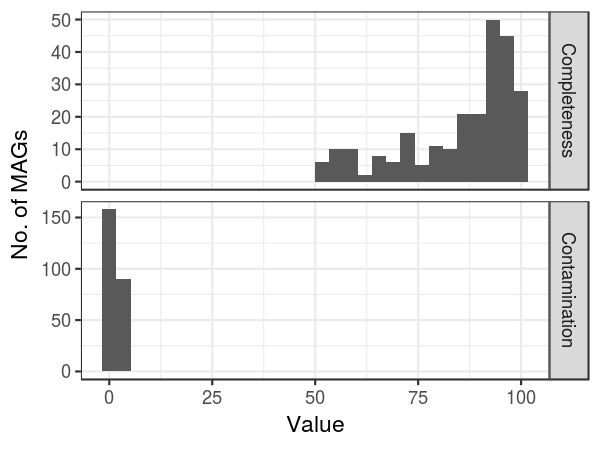

In [47]:
# checkm stats
drep_res_j$Completeness %>% summary %>% print
drep_res_j$Completeness %>% sd %>% print
drep_res_j$Contamination %>% summary %>% print
drep_res_j$Contamination %>% sd %>% print

p = drep_res_j %>%
    dplyr::select(binID, Completeness, Contamination) %>%
    gather(Metric, Value, -binID) %>%
    ggplot(aes(Value)) +
    geom_histogram(bins=30) +
    labs(y='No. of MAGs') +
    facet_grid(Metric ~ ., scales='free_y') +
    theme_bw() 

dims(4,3)
Plot(p)

In [48]:
cat('Number of "high quality" genomes:', 
    drep_res_j %>% filter(Completeness >= 90) %>% nrow, '\n')

Number of "high quality" genomes: 133 


## GTDBTk

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/04_assemblies/01_LLMGA/06_summary/.figures/21155b7f6ec3ffaedfae441626fd9b88.RDS 


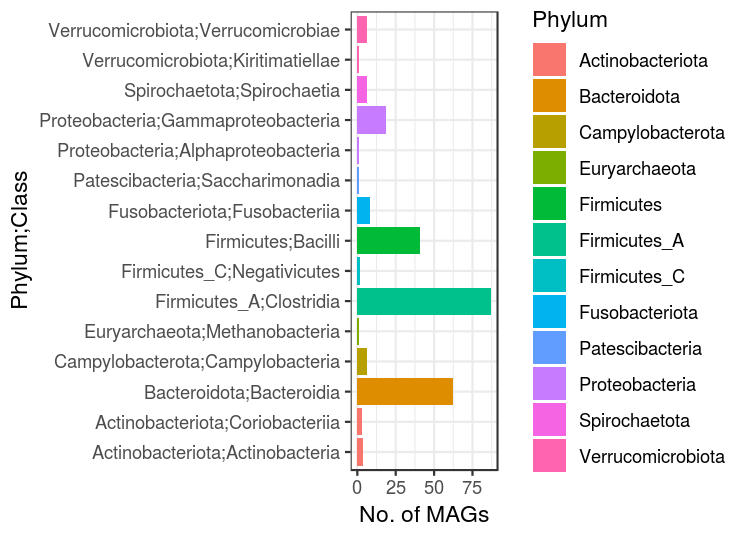

In [53]:
# Total by class
p = drep_res_j %>%
    mutate(Phylum = gsub('^p__', '', Phylum),
           Class = gsub('^c__', '', Class)) %>%
    unite(Taxonomy, Phylum, Class, sep=';', remove=FALSE) %>%
    group_by(Taxonomy, Phylum) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    ggplot(aes(Taxonomy, n, fill=Phylum)) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(x='Phylum;Class', y='No. of MAGs') +
    theme_bw() 

dims(5,3.6)
Plot(p)

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/04_assemblies/01_LLMGA/06_summary/.figures/b9eb1d531709d986a98578f650daecdb.RDS 


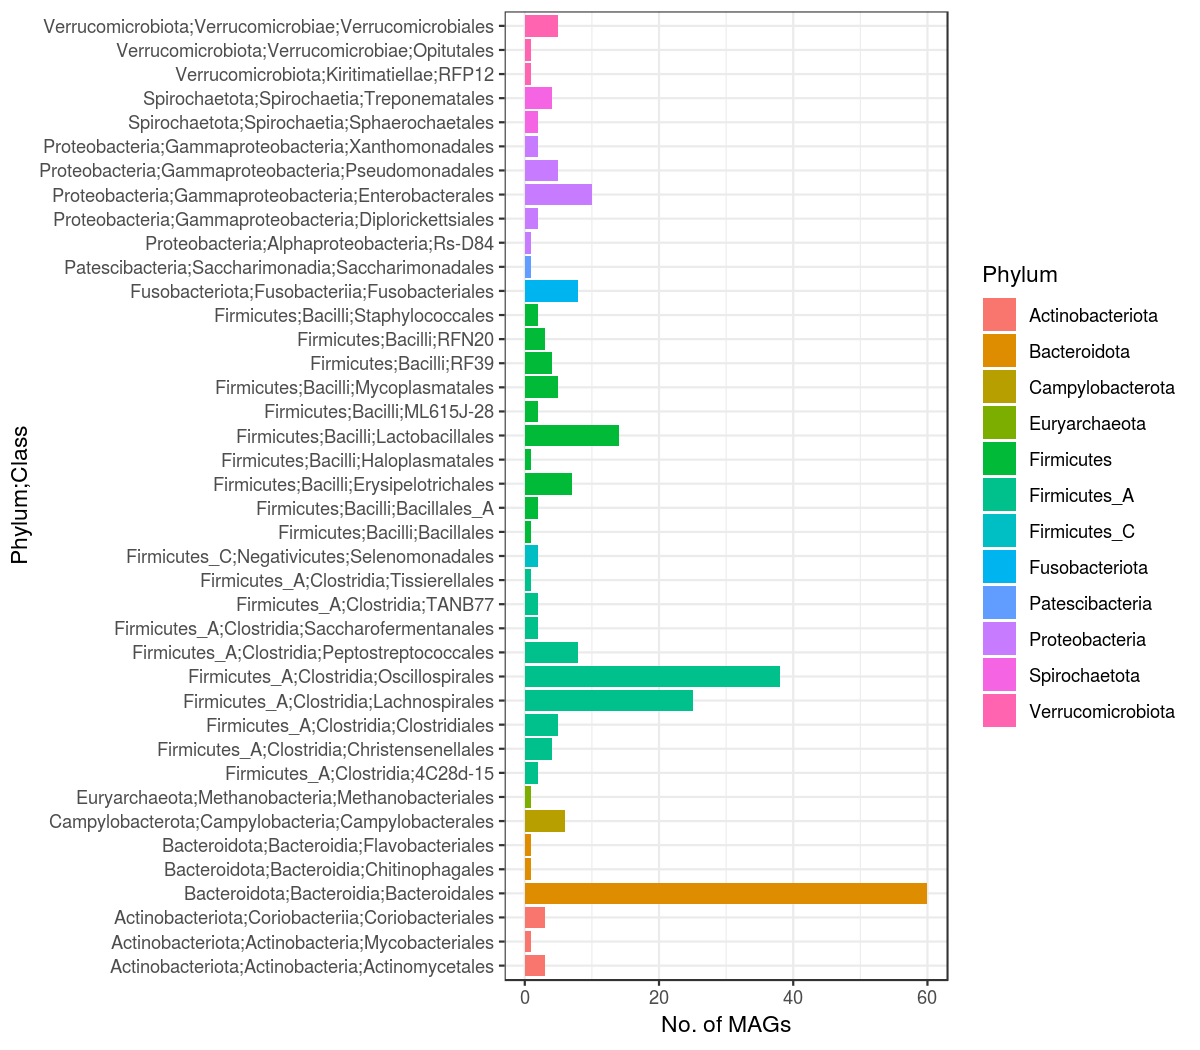

In [55]:
# Total by order
p = drep_res_j %>%
    mutate(Phylum = gsub('^p__', '', Phylum),
           Class = gsub('^c__', '', Class),
           Order = gsub('^o__', '', Order)) %>%
    unite(Taxonomy, Phylum, Class, Order, sep=';', remove=FALSE) %>%
    group_by(Taxonomy, Phylum) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    ggplot(aes(Taxonomy, n, fill=Phylum)) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(x='Phylum;Class', y='No. of MAGs') +
    theme_bw() 

dims(8,7)
Plot(p)

In [56]:
# Christ. genomes
drep_res_j %>%
    filter(Order == 'o__Christensenellales') %>%
    nrow %>% print
# Methanogen genomes
drep_res_j %>%
    filter(Domain == 'd__Archaea',
           grepl('^c__Methano', Class)) %>%
    nrow %>% print

[1] 4
[1] 1


[1] 52
[1] 196
File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/metagenome/HiSeqRuns126-133-0138/wOutVertebrata/04_assemblies/01_LLMGA/06_summary/.figures/6fa55e8b06fb9edc537a5d5fc50a61b0.RDS 


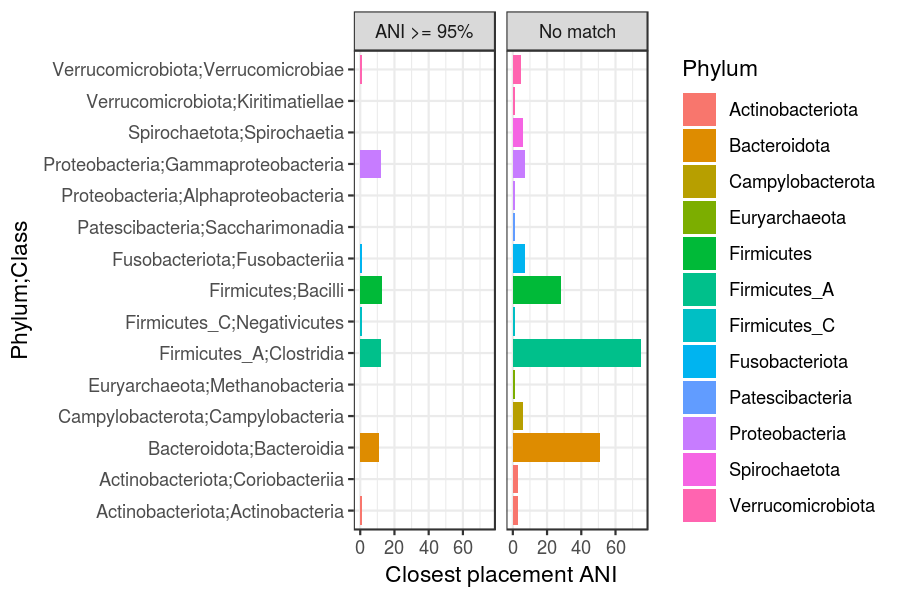

In [57]:
# no close ANI matches 
x = drep_res_j %>%
    mutate(Phylum = gsub('^p__', '', Phylum),
           Class = gsub('^c__', '', Class),
           Order = gsub('^o__', '', Order)) %>%
    unite(Taxonomy, Phylum, Class, sep=';', remove=FALSE) %>%
    mutate(closest_placement_ani = closest_placement_ani %>% as.character,
           closest_placement_ani = ifelse(closest_placement_ani == 'N/A', 
                                          0, closest_placement_ani),
           closest_placement_ani = ifelse(is.na(closest_placement_ani), 
                                          0, closest_placement_ani),
           closest_placement_ani = closest_placement_ani %>% as.Num) %>%
    mutate(has_species_placement = ifelse(closest_placement_ani >= 95,
                                          'ANI >= 95%', 'No match')) 

# number
x %>% filter(has_species_placement == 'ANI >= 95%') %>% nrow %>% print
x %>% filter(has_species_placement == 'No match') %>% nrow %>% print

# plot
p = x %>%
    ggplot(aes(Taxonomy, fill=Phylum)) +
    geom_bar() +
    facet_grid(. ~ has_species_placement) +
    coord_flip() +
    labs(x='Phylum;Class', y='Closest placement ANI') +
    theme_bw() 

dims(6,4)
Plot(p)

Number of genomes lacking a genus-level classification: 51 


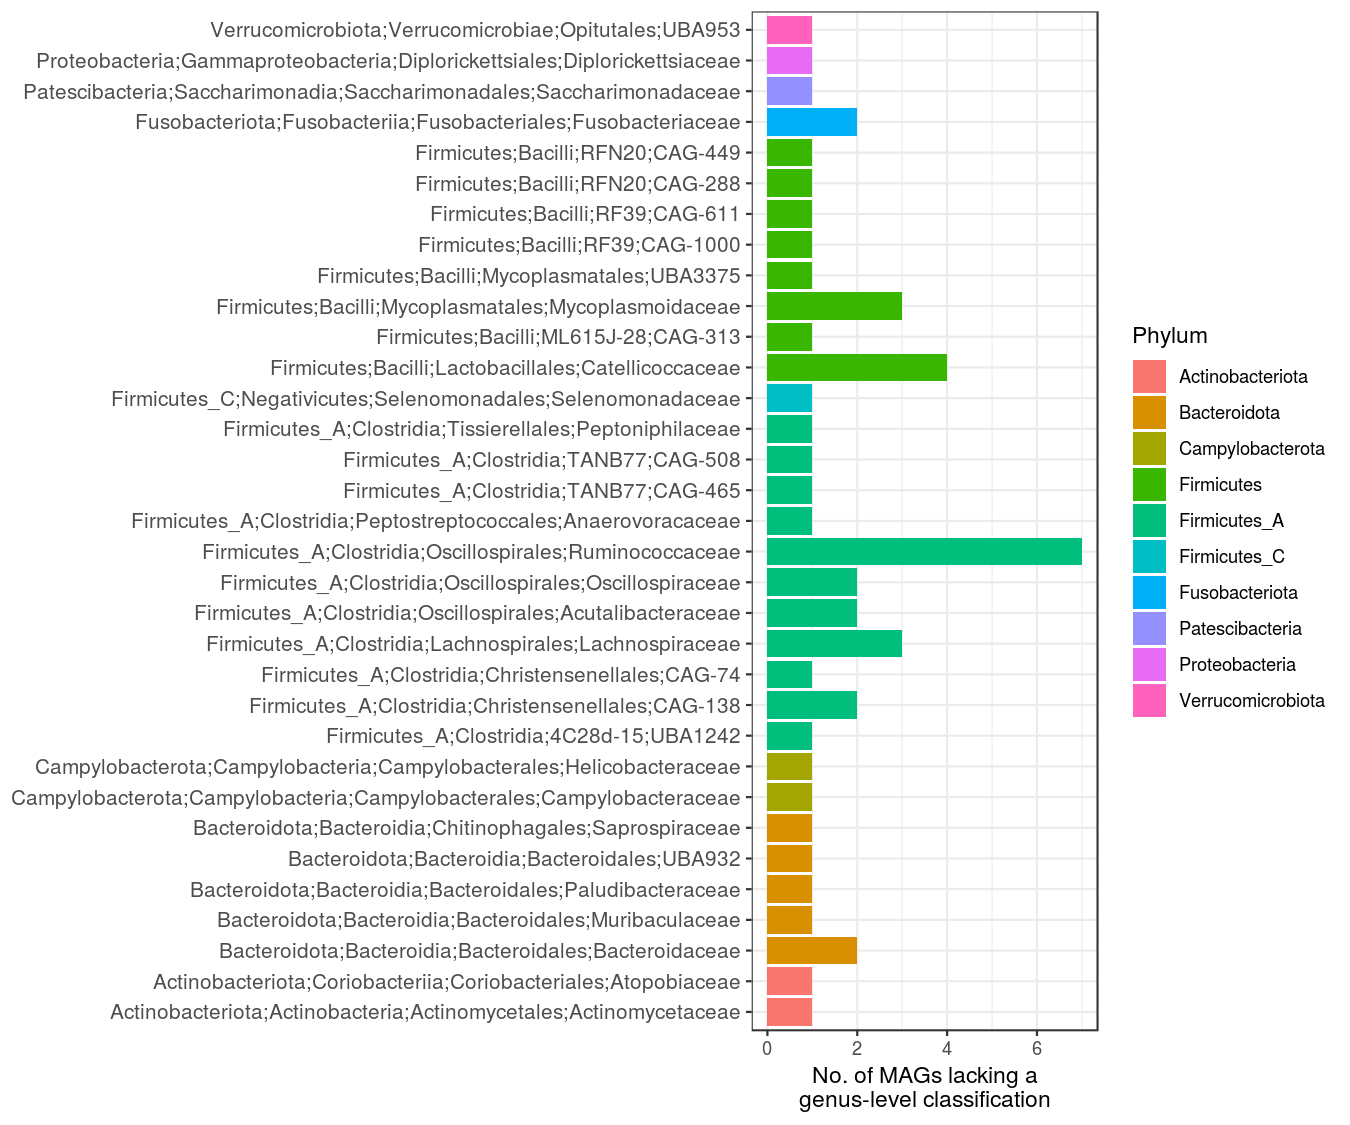

In [58]:
drep_j_s = drep_res_j %>%
    filter(Genus == 'g__') %>%
    mutate(Phylum = gsub('^p__', '', Phylum),
           Class = gsub('^c__', '', Class),
           Order = gsub('^o__', '', Order),
           Family = gsub('^f__', '', Family)) %>%
    unite(Taxonomy, Phylum, Class, Order, Family, sep=';', remove=FALSE) %>%
    group_by(Taxonomy, Phylum) %>%
    summarize(n = n()) %>%
    ungroup()

cat('Number of genomes lacking a genus-level classification:',
    drep_j_s$n %>% sum, '\n')

p = drep_j_s %>%
    ggplot(aes(Taxonomy, n, fill=Phylum)) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(y='No. of MAGs lacking a\ngenus-level classification') +
    theme_bw() +
    theme(
        axis.text.y = element_text(size=10),
        axis.title.y = element_blank()
    )

dims(9,7.5)
plot(p)

# sessionInfo

In [59]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
 [4] future_1.9.0            doParallel_1.0.11       iterators_1.0.10       
 [7] foreach_1.4.4           data.table_1.11.4       ggplot2_3.0.0          
[10] tidyr_0.8.1             dplyr_0.7.6            

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-2      progress_1.2.0    tidyselect_0.2.4  repr_0.15.0      
 [5] reshape2_1.4.3    purrr_0.2.4       listenv_0.7.0     colorspace_1.3-2 
 [9] htmltools_0.3.6   base64enc_0.1-3   r